# Predicting Delays for US Flights

by David Schneemann

## Project Goal

My goal with this project is to identify key drivers of flight delays and to provide insight into why and how these factors influence flight delays. With this information and the following recommendations, we can have a better understanding of how to avoid booking flights in the future that have a strong likelihood of producing delays. 

## Project Description

In the US, there are over 45,000 flights happening each and every day. At any given time, there are over 5000 flights in the sky at once. These vast quantities underline the importance of maintaining flights that have minimal issues and delays. However, delays do happen on a regular basis. The question is, can we predict when, where, and for how long those delays will be in the future?

In order to more accurately predict flight delays, we will analyze the attributes (features) of flights within a predetermined set of data. This dataset includes all US flights conducted during the year 2007. 
We will then develop models for predicting flight delays based on these attributes and provide recommendations and predictions for improving prediction of delays moving forward.

## Executive Summary

This report performs exploration, analysis, and modeling to predict future flight delays. \
I ask 5 initial questions of the data, creating visuals and performing statistical analysis. \
I conclude with a comparison of 3 separate regression models that analyze flight data and corresponding delays from a sample of the data. 

I then perform predictions on data not seen by these models. \
The results from my top model indicate that it will perform over 9% better than our baseline prediction on future data it has not seen. \
My conclusory summary at the end of the report highlights potential recommendations and next steps. 

-----------------------------------------------------------------------------------------------------------
## Initial Questions

#### 1. Do flights in August have higher average flight delays than than the annual average? 

#### 2. Do flights on Thursdays have higher average flight delays than the weekly average?

#### 3. Does JetBlue Airways have greater flight delays than the carrier national average?

#### 4. Does Detroit airport have greater flight delays than the overall average airport delay?

#### 5. Does total_time_diff have a relationship to flight delay?

-----------------------------------------------------------------------------------------------------------
## Data Dictionary

In order to effectively meet our goals, the following module imports are required. \
Below is an extensive list of all modules I imported and used to create and complete the desired analysis.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from datetime import timedelta, datetime
import csv

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from scipy import stats
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import stats, pearsonr, spearmanr, kruskal, levene

from env import user, password, host
import flight_delay_acquire
import flight_delay_prepare
import explore
import scale

|Index| Variable         | Variable descriptions                                                |
|---:|:------------------|:---------------------------------------------------------------------|
|  1 | Name              | Description                                                          |
|  2 | Year              | 2007                                                                 |
|  3 | Month             | Month of the year                                                    |
|  4 | dayofmonth        | 31-Jan                                                               |
|  5 | dayofweek         | 1 (Monday) - 7 (Sunday)                                              |
|  6 | depart            | Actual departure time (local, hhmm)                                  |
|  7 | scheduled_depart  | Scheduled departure time (local, hhmm)                               |
|  8 | arrive            | Actual arrival time (local, hhmm)                                    |
|  9 | scheduled_arrive  | Scheduled arrival time (local, hhmm)                                 |
| 10 | UniqueCarrier     | Unique carrier code                                                  |
| 11 | FlightNum         | Flight number                                                        |
| 12 | TailNum           | Plane tail number                                                    |
| 13 | total_time        | Total actual time from departure to arrival (in minutes)             |
| 14 | scheduled_total_time    | Total scheduled time from departure to arrival (in minutes)    |
| 15 | AirTime           | Total time in air (in minutes)                                                           |
| 16 | ArrDelay          | Arrival delay, in minutes                                            |
| 17 | DepDelay          | Departure delay, in minutes                                          |
| 18 | Origin            | Origin IATA airport code                                             |
| 19 | Dest              | Destination IATA airport code                                        |
| 20 | Distance          | in miles                                                             |
| 21 | TaxiIn            | Taxi in time, in minutes                                             |
| 22 | TaxiOut           | Taxi out time in minutes                                             |
| 23 | Cancelled         | Was the flight cancelled?                                            |
| 25 | Diverted          | 1 = yes, 0 = no                                                      |
| 26 | CarrierDelay      | in minutes                                                           |
| 27 | WeatherDelay      | in minutes                                                           |
| 28 | NASDelay          | National Aviation System (in minutes)                                |
| 29 | SecurityDelay     | in minutes                                                           |
| 30 | LateAircraftDelay | in minutes                                                           |
| 31 | total_delay       | Total Delay (Arrival + Departure delays)                             |
| 32 | total_time_diff   | Difference between actual total time and scheduled total time        |

## Acquire Flight Data

##### We acquire our data by utilizing my acquire.py file.
This file pulls my selected features from the 2007.csv. \
Our resulting dataset returns 7,453,215 entries of data with the following attributes.

In [2]:
# Calling my acquire.py file and utilizing its function,assigning the output to df
df = flight_delay_acquire.wrangle_flight_delay()

## Prepare Flight Data

##### We prepare our data by utilizing my prepare.py file.
This file:
- Handles null values
    - These null values represented roughly 2% of our data, so I chose to drop these rows
- Converts some variables to integers for optimization
- Handles outliers
- Cleans variables, including dropping `Diverted` and renaming columns
- Includes feature engineering for multiple variables
- Splits prepared df into train, validate, test, and associated dfs on x and y

Our resulting dataframes are ready for exploration and evaluation.

In [3]:
# Calling my prepare function and assigning the output to the following variables
df, train, validate, test, x_train, y_train, x_validate, y_validate, x_test, y_test = flight_delay_prepare.prep_flight_delay(df)

In [4]:
# Checking shape on our samples to confirm appropriate split
print('Total df shape: {}.'.format(df.shape))
print('Train shape: {}.'.format(train.shape))
print('Validate shape: {}.'.format(validate.shape))
print('Test shape: {}.'.format(test.shape))

Total df shape: (7275288, 56).
Train shape: (4074161, 56).
Validate shape: (1746069, 56).
Test shape: (1455058, 56).


## Set the Data Context

#### Note: Not all visuals, analysis, and work is shown within this Final Report. 
#### All my work, from start to finish, is available in my `working_notebook.ipynb` file for your reference.

Our acquired and prepared dataset contains information for 7,275,288 flights throughout 2007. \
    In the process of exploring this data and setting initial hypotheses, I created a figure plotting choice categorical and continuous variables with our target variable of `total_delay`. Using this figure I determined potential relationships with each of the features stated in my initial hypotheses. The following exploration seeks to answer these questions.

-----------------------------------------------------------------------------------------------------------
## Exploratory Analysis
I now take each of my initial hypotheses in turn, answering them using visualizations and statistical analysis. \
I utilize an `explore.py` file in order to abstract repetitive code away from this Final Report. 

### 1. Do flights in August have higher average flight delays than than the annual average? 

- Ho = August flights avg total_delay <= average annual total_delay
- Ha = August flights avg total_delay > average annual total_delay

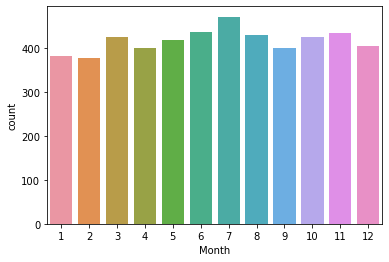

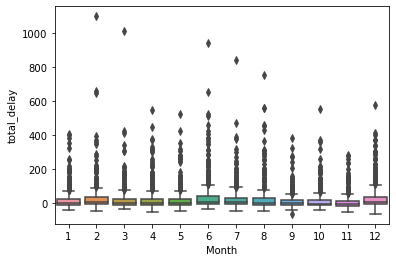

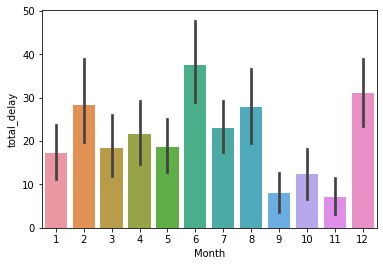

In [5]:
# Calling explore.py; applying plot function to 'Month' and 'total_delay'
explore.plot_categorical_and_continuous_vars(train, 'Month', 'total_delay')

#### Statistical Analysis

In [6]:
# Use the scipy stats function one-sample t-test to calculate p-value
August = train[train['Month'] == 8].total_delay
alpha = 0.05

delay_sample = August
overall_mean = train.total_delay.mean()


t, p = stats.ttest_1samp(delay_sample, overall_mean)

print(f't-statistic by one-sample t-test: {t}, p-value: {p}, alpha: {alpha}')

if p/2 > alpha:
    print("We fail to reject Ho")
elif t < 0:
    print("We fail to reject Ho")
else:
    print("We reject Ho")


t-statistic by one-sample t-test: 33.41607320208134, p-value: 1.916525927761137e-244, alpha: 0.05
We reject Ho


#### Answer 1 : Yes, from our visualizations and statistical analysis, we can express confidence that August flights have higher average flight delays than other months' average delay.
Following our statistical test, we indicate that this feature appears to show a strong relationship with total_delay, meaning that there is statistical significance behind the claim that average delay in August relates to total_delay. Thus we move forward with this feature.

-----------------------------------------------------------------------------------------------------------
### 2. Do flights on Thursdays have higher average flight delays than the weekly average?
- Ho = Thursday flights avg total_delay <= average weekly total_delay
- Ha = Thursday flights avg total_delay > average weekly total_delay

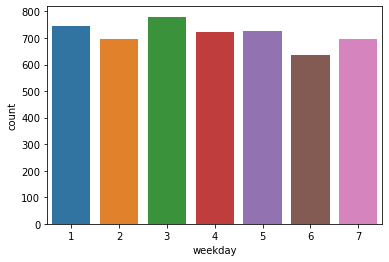

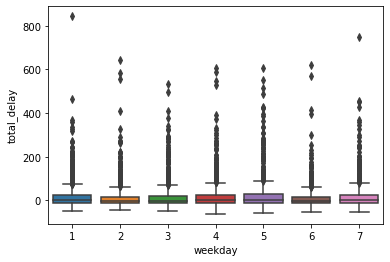

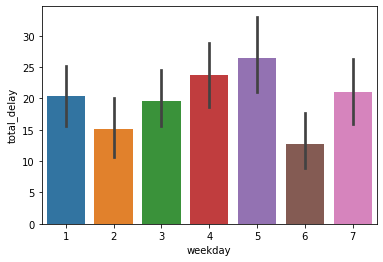

In [7]:
# Calling explore.py; applying plot function to 'weekday' and 'total_delay'
explore.plot_categorical_and_continuous_vars(train, 'weekday', 'total_delay')

In [8]:
# Use the scipy stats function one-sample t-test to calculate p-value
Thursday = train[train.weekday == 4].total_delay
alpha = 0.05


delay_sample = Thursday
overall_mean = train.total_delay.mean()

t, p = stats.ttest_1samp(delay_sample, overall_mean)

print(f't-statistic by one-sample t-test: {t}, p-value: {p}, alpha: {alpha}')

if p/2 > alpha:
    print("We fail to reject Ho")
elif t < 0:
    print("We fail to reject Ho")
else:
    print("We reject Ho")

t-statistic by one-sample t-test: 39.04023030279991, p-value: 0.0, alpha: 0.05
We reject Ho


#### Answer 2: Yes, from our visualizations and statistical analysis, we can express confidence that Thursday flights have higher average flight delays than other weekdays' average delay.
Following our statistical test, we indicate that this feature appears to show a strong relationship with total_delay, meaning that there is statistical significance behind the claim that average delay on Thursdays relates to total_delay. Thus we move forward with this feature.

-----------------------------------------------------------------------------------------------------------
### 3. Does JetBlue Airways have greater flight delays than the carrier national average?

- Ho = JetBlue Airways flights avg total_delay <= average carrier total_delay
- Ha = JetBlue Airways flights avg total_delay > average carrier total_delay

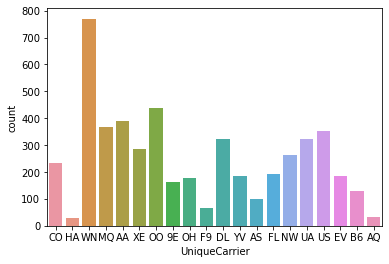

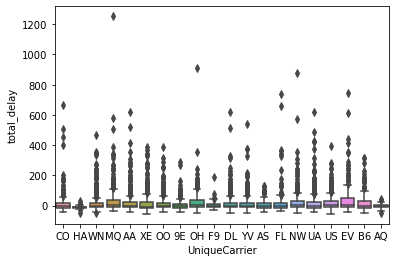

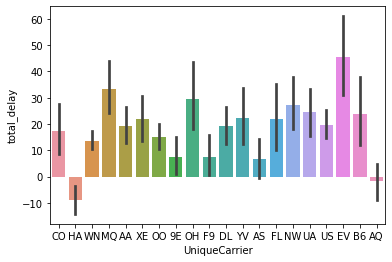

In [9]:
# Calling explore.py; applying plot function to 'UniqueCarrier' and 'total_delay'
explore.plot_categorical_and_continuous_vars(train, 'UniqueCarrier', 'total_delay')

In [10]:
# Use the scipy stats function one-sample t-test to calculate p-value
JetBlue = train[train.UniqueCarrier == 'B6'].total_delay
alpha = 0.05

delay_sample = JetBlue
overall_mean = train.total_delay.mean()

t, p = stats.ttest_1samp(delay_sample, overall_mean)

print(f't-statistic by one-sample t-test: {t}, p-value: {p}, alpha: {alpha}')

if p > alpha:
    print("We fail to reject Ho")
elif t < 0:
    print("We fail to reject Ho")
else:
    print("We reject Ho")

t-statistic by one-sample t-test: 23.504905340951467, p-value: 7.513561490281929e-122, alpha: 0.05
We reject Ho


#### Answer 3: Yes, from our visualizations and statistical analysis, we can express confidence that JetBlue Airways flights have higher average flight delays than other airlines' average delay.
Following our statistical test, we indicate that this feature appears to show a strong relationship with total_delay, meaning that there is statistical significance behind the claim that average delay JetBlue flights relates to total_delay. Thus we move forward with this feature.

-----------------------------------------------------------------------------------------------------------
### 4. Does Detroit airport have greater flight delays than the overall average airport delay?
- Ho = Flights out of Detroit airport avg total_delay <= the overall average airport total_delay
- Ha = Flights out of Detroit airport avg total_delay > the overall average airport total_delay

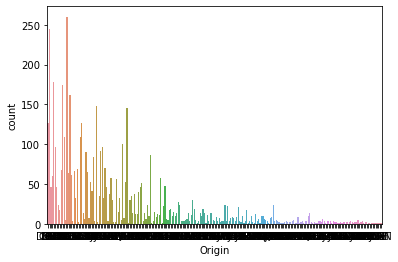

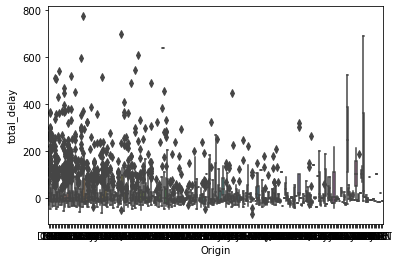

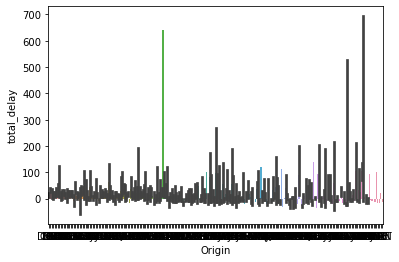

In [11]:
# Calling explore.py; applying plot function to 'Origin' and 'total_delay'
explore.plot_categorical_and_continuous_vars(train, 'Origin', 'total_delay')

In [12]:
# Use the scipy stats function one-sample t-test to calculate p-value
Detroit = train[train.Origin == 'DTW'].total_delay
alpha = 0.05

delay_sample = Detroit
overall_mean = train.total_delay.mean()

t, p = stats.ttest_1samp(delay_sample, overall_mean)

print(f't-statistic by one-sample t-test: {t}, p-value: {p}, alpha: {alpha}')

if p/2 > alpha:
    print("We fail to reject Ho")
elif t < 0:
    print("We fail to reject Ho")
else:
    print("We reject Ho")

t-statistic by one-sample t-test: 10.083018026405284, p-value: 6.749637068545843e-24, alpha: 0.05
We reject Ho


#### Answer 4: Yes, from our visualizations and statistical analysis, we can express confidence that Detroit flights have higher average flight delays than all other airports' average delay.
Following our statistical test, we indicate that this feature appears to show a strong relationship with total_delay, meaning that there is statistical significance behind the claim that average delay at Detroit airport relates to total_delay. Thus we move forward with this feature.

-----------------------------------------------------------------------------------------------------------
### 5. Does total_time_diff have a relationship to flight delay?
- Ho = More total_time_diff translates to <= total_delay 
- Ha = More total_time_diff translates to > total_delay

<Figure size 432x288 with 0 Axes>

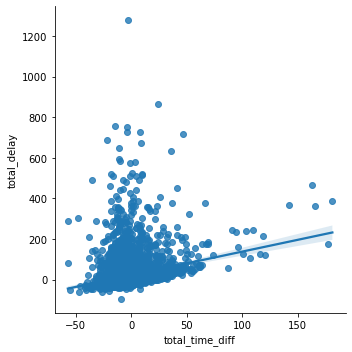

<Figure size 432x288 with 0 Axes>

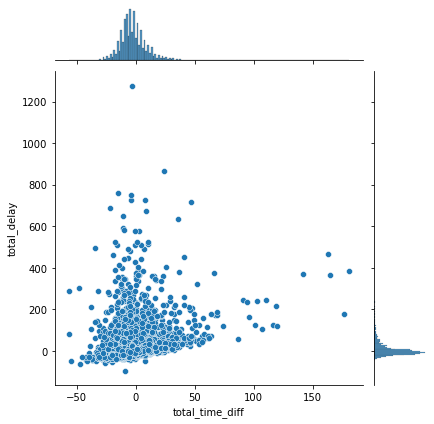

In [13]:
# Calling explore.py; applying two continuous vars plot function to 'total_time_diff' and 'total_delay'
explore.plot_continuous_and_continuous_vars(train, 'total_time_diff', 'total_delay')

In [14]:
# Use the scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r_sf, p_sf = pearsonr(train['total_time_diff'], train['total_delay'])

r_sf, p_sf

print(f'Correlation Coefficient by Pearson Test: {r_sf}, p-value: {p_sf}')

# set alpha : 0.05
if p_sf < 0.05:
    print('We can reject the null hypothesis')
else:
    print('we cannot reject the null hypothesis')

Correlation Coefficient by Pearson Test: 0.23141340329024448, p-value: 0.0
We can reject the null hypothesis


#### Answer 5: Yes, Difference between actual total time and scheduled total time correlates with an increase in total_delay
Following our statistical test, we reject the null, meaning that there is statistical significance behind the claim that an increase in total_time_diff correlates with an increase in total_delay. Thus, we move forward with this feature.

-----------------------------------------------------------------------------------------------------------
## Exploration Summary: Which are the best predictors of flight delay?

#### Key Takeaways
##### All 5 features I explored have been shown to have a potentiaal relationship or correlation with total_delay, thus I'll move forward with these features to modeling:
- `Month` 
- `weekday` 
- `UniqueCarrier` 
- `Origin`
- `total_time_diff` 

##### In an attempt to produce the most accurate models possible, I will drop the following troublesome or extraneous features:
- `Year`
- `ArrDelay`
- `DepDelay`
- `CarrierDelay`
- `WeatherDelay`
- `NASDelay`
- `SecurityDelay`
- `LateAircraftDelay`
- `FlightNum`
- `TailNum`
- `Cancelled`
- `Diverted`
- `Dest`


#### Additional Takeaways

##### 1. Carrier Delays appear to be most prominent and the longest on average of all delays

##### 2. Certain Carriers have more Carrier Delays than others; Carriers with highest delays:
    - JetBlue Airways
    - American Airlines (may be due to number of flights comparatively)
    - Envoy Air

##### 3. It appears airlines regularly include extra scheduled flight time
    - Even with small delays, pilots are usually able to make up time in the air, thus:
        - Departure Delays seem to be greater than Arrival Delays on average
        - Even if departure delays occur, on average, flights are able to diminish this delay by reducing flight time

##### 4. The difference in actual total time of a flight and total scheduled time has a negative correlation with weekends and Mondays. Could be indicator of a cultural/human phenomenon where people move faster because they want to finish the job and get home.

##### 5. Despite Southwest conducting the most flights of any carrier, I can be confident in stating that they are able to maintain an average flight delay as good or better than the national carrier average

-----------------------------------------------------------------------------------------------------------
## Predicting Total Flight Delay
In fitting and evaluating models on our data, the metric we choose to use to evaluate is root mean square error (RMSE). This allows us to compare the mean error of a model in the actual units of our target variable, `total_delay` (in minutes). Thus, this is the most valuable metric for understanding the performance of our models.

### Scaling
I have chosen a Robust Scaler upon which to scale my data. After comparing this and other scalers, I determined Robust to provide the best results due to the presence of outliers. I call my `model.py` scaling function and assign respective variables below.

Additionally, below I remove extraneous features not already removed.

In [15]:
# Dropping Month, UniqueCarrier, and weekday due to previous encoding of these variables
train = train.drop(columns='Month', axis =1)
validate = validate.drop(columns='Month', axis =1)
test = test.drop(columns='Month', axis =1)

train = train.drop(columns='UniqueCarrier', axis =1)
validate = validate.drop(columns='UniqueCarrier', axis =1)
test = test.drop(columns='UniqueCarrier', axis =1)

train = train.drop(columns='weekday', axis =1)
validate = validate.drop(columns='weekday', axis =1)
test = test.drop(columns='weekday', axis =1)

train = train.drop(columns='Origin', axis =1)
validate = validate.drop(columns='Origin', axis =1)
test = test.drop(columns='Origin', axis =1)

In [16]:
# Calling our model.py; Assigning df variables to our called function, `scale_data`
train_scaled, validate_scaled, test_scaled = scale.robust_scale_data(train, validate, test)

#### Now that we have our data scaled, I will:
- Split our scaled train, validate, and test on x and y

In [17]:
# Splitting train, validate, and test dfs on x and y FOR SCALED DF
x_train_scaled = train_scaled.drop(columns=['total_delay'])
x_validate_scaled = validate_scaled.drop(columns=['total_delay'])
x_test_scaled = test_scaled.drop(columns=['total_delay'])

y_train_scaled = train_scaled['total_delay']
y_validate_scaled = validate_scaled['total_delay']
y_test_scaled = test_scaled['total_delay']

#### Baseline
In order to compare our models, I'll create a baseline from our train dataset actual home values

In [18]:
#Establish baselines for the train and validation datasets
baseline = train['total_delay'].mean()

# Create new columns for baseline
train['baseline'] = baseline
validate['baseline'] = baseline
test['baseline'] = baseline

# Find RMSE for each sample
train_rmse = sqrt(mean_squared_error(train['total_delay'], train.baseline))
validate_rmse = sqrt(mean_squared_error(validate['total_delay'], validate.baseline))
test_rmse = sqrt(mean_squared_error(test['total_delay'], test.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))
print('Test baseline RMSE: {}.'.format(test_rmse))

Train baseline RMSE: 73.97018296644863.
Validation baseline RMSE: 74.29186557797719.
Test baseline RMSE: 74.05859989363883.


I'll now create:
- `train_predictions` df for our train predictions 
- `predictions` df for our validate predictions

In [19]:
# Creating dfs for train and validate predictions
train_predictions = pd.DataFrame({
    'actual': train['total_delay'],
    'baseline': baseline
}) 

predictions = pd.DataFrame({
    'actual': validate['total_delay'],
    'baseline': baseline
}) 

### Fit 3 Best Models
- Linear Regression (`simple_lm`)
- Lasso-Lars Regression (`lasso_lars`)
- TweediRegressor (`glm`)

#### Fitting Linear Regression

In [20]:
# Create an instance of the model and fit it to my data
lm = LinearRegression().fit(x_train_scaled, y_train_scaled)

# Predicting on train and validate and adding column to both predictions dfs 
train_predictions['simple_lm'] = lm.predict(x_train_scaled)
predictions['simple_lm'] = lm.predict(x_validate_scaled)

#### Fitting Lasso-Lars Regression

In [21]:
# Create the model object
lars = LassoLars(alpha=1)

# Fit the model to our training data
lars.fit(x_train_scaled, y_train_scaled)

# predict train
train_predictions['lasso_lars'] = lars.predict(x_train_scaled)

# Predict validate
predictions['lasso_lars'] = lars.predict(x_validate_scaled)

#### Fitting TweediRegressor

In [22]:
# Create the model object
glm = TweedieRegressor(power=0, alpha=1)

# Fit the model to our training data
glm.fit(x_train_scaled, y_train_scaled)

# predict train, add to df
train_predictions['glm'] = glm.predict(x_train_scaled)

# Predict validate, add to df
predictions['glm'] = glm.predict(x_validate_scaled)

#### Evaluating Models using root mean squared error (RMSE)

In [23]:
# Calculate root mean squared error (RMSE) for every column in the train_predictions df
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(train_predictions.actual, y_predicted))

print('Train baseline RMSE: {}.'.format(train_rmse))
train_predictions.apply(calculate_rmse).sort_values()

Train baseline RMSE: 73.97018296644863.


actual         0.000000
simple_lm     67.511929
glm           68.698877
baseline      73.970183
lasso_lars    73.970183
dtype: float64

In [24]:
# Calculate root mean squared error (RMSE) for every column in the predictions df
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions.actual, y_predicted))

print('Validation baseline RMSE: {}.'.format(validate_rmse))
predictions.apply(calculate_rmse).sort_values()

Validation baseline RMSE: 74.29186557797719.


actual         0.000000
simple_lm     67.950122
glm           69.119541
baseline      74.291866
lasso_lars    74.291866
dtype: float64

##### Model Conclusion: 
Based on comparing our train and validate predictions, we can say with confidence that Linear Regression (`simple_lm`) is our best performing model. We will now predict and evaluate this model on our test dataset

### Predict and Evaluate Test dataset
Like with train and validate, I'll create a predictions df to collect predictions and then evaluate.

In [25]:
test_predictions = pd.DataFrame({
    'actual': test['total_delay'],
    'baseline': baseline
}) 

In [26]:
#Create an instance of the model and fit it to my data
lm = LinearRegression().fit(x_train_scaled, y_train_scaled)

# Predict on test
test_predictions['simple_lm'] = lm.predict(x_test_scaled)

test_predictions.head()

,actual,baseline,simple_lm
1949761,-30,21.516436,-2.415426
6855023,69,21.516436,65.013864
3193222,3,21.516436,36.521975
4269503,-13,21.516436,31.191714
5812076,-10,21.516436,3.027917


In [27]:
# Calculate root mean squared error (RMSE) for the test_predictions df
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(test_predictions.actual, y_predicted))

print('Test baseline RMSE: {}.'.format(test_rmse))
test_predictions.apply(calculate_rmse).sort_values()

Test baseline RMSE: 74.05859989363883.


actual        0.000000
simple_lm    67.606355
baseline     74.058600
dtype: float64

In [28]:
test_result = test_predictions.apply(calculate_rmse).sort_values()

In [29]:
# Finding by how much my model beat baseline 
model_percent = abs((test_result['simple_lm'] - test_rmse) / ((test_result['simple_lm'] + test_rmse) / 2))

print("The model beat baseline by: "+"{:.2%}".format(model_percent))

The model beat baseline by: 9.11%


**Success!**

From this calculation on our test dataset, we can observe that my Linear Regression model successfully beat our baseline.

**Our model performs 9.11% better than baseline**

-----------------------------------------------------------------------------------------------------------
## Conclusion

### Summary

In seeking solutions to more accurately predict total flight delay, we have explored a multiplicity of factors in the dataset that affect flight delays. We have shown that some potential primary drivers of flight delays are :

- The month out of the year 
- The day of the week 
- The carrier flown
- The airport one departs from
- The difference between actual total time versus scheduled total time

The correlation of these features with flight delays, combined within our analysis and models, expresses confidence in the validity of our findings. We have created robust models that perform significantly better than our baseline estimated error of 74 minutes.

Having fit the best performing model to our train, validate, and test datasets, we expect this model to perform 9.11% better than our baseline in the future on data it has not seen, given no major changes to our data source.

### Recommendations

There are a number of recommendations that can be offered based on the above analysis. These suggestions are tied to the findings within our primary drivers of total flight delay:

1. Keep in mind the month in which a flight occurs. Certain peak travel months like August and December will almost inevitably have longer and more frequent delays than other months. 
2. The day of the week influences the potential for delay. Thursdays in particular were potentially shown to have more delays than other days of the week. 
3. The carrier chosen to fly with has particular importance for avoiding delays. For example, my statistical testing expressed confidence that Southwest Airlines have as many of fewer delays than the national carrier average despite being the biggest carrier in 2007 by a sizable margin. Inversely, JetBlue Airways has more and longer delays than the national carrier average despite being a smaller carrier with less overall flights flown.
4. The airport one flies out of does play a role in potential delays. Although this isn't necessarily a varaiable choice for most, it can inform a customer of increased potential for delays and allow them to plan accordingly.

### Next Steps

Despite the overall effectiveness of our best-performing model, there is always room for improvement and optimization. \
If given more time to pursue a better results, I would begin by conducting further exploration and analysis of other features within our dataset. These features could include:
- The difference in actual departure time vs scheduled departure time
- A deeper analysis of delay by carrier, further extrapolating on different key carriers
- An analysis of whether the week of the month influences flight delays

In addition to exploring other features, I would look into methods for more appropriately separating our data into additional delay categories. For example:
- Breaking down total flight delay by delay segments (i.e. short, medium, and long delays)
- Analysis drawn from additional minor datasets provided
    - Namely, types and models of aircraft utilized by different carriers and their overall performance and consistency

By optimizing our dataset to include the above categories, I believe we could increase the strength of relationship of our feature set with total flight delay and improve model prediction accuracy.